In [88]:
import os
import pandas as pd
from dotenv import load_dotenv
from steam_web_api import Steam
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from sklearn.linear_model import LinearRegression

In [17]:
# Load environment variables
load_dotenv()
KEY = os.getenv("STEAM_API_KEY")
steam = Steam(KEY)

In [19]:
#test to make sure the api key is working properly
gamer = steam.users.get_owned_games(76561197960288464)
gamerdf = pd.DataFrame.from_dict(gamer)
print(gamerdf['game_count'][0])
#the output should be 161

161


The code is designed to analyze gaming habits of a group of "normie" gamers by utilizing the Steam API to fetch their owned games and playtime data. For each Steam ID in the provided list, the code retrieves game details, calculates the total hours played across all games, and identifies the most-played game based on lifetime playtime. It also checks for recent playtime within the last two weeks and handles cases where no games are found or where recent playtime data is missing. The data is then compiled into a DataFrame, with relevant columns such as total hours played, most-played game, and playtime for each game, before being saved into a CSV file for further analysis. 

The generated bar graph visualizes the top 10 most-played games among these users by aggregating total hours played across all accounts. The graph reveals that "Counter-Strike 2," "Counter-Strike," and "Team Fortress 2" are the most-played games, with significantly higher total playtime compared to others. This indicates these games' enduring popularity and appeal to casual gamers. The graph provides a clear comparison of total hours played for the top games, emphasizing their dominant presence in the gaming habits of the analyzed users.

In [19]:
#Open the normies_random.txt to read in the userID's we will use for the dataset
with open("normies_random.txt", "r") as f:
    Normie_ids = [line.strip() for line in f if line.strip()]

In [20]:
#Inputting a normie userID in Steam's getownedgames
#taking the data returned and making a list of dataframes for each user and their data
normie_data = []
for id in Normie_ids:
    try:
        response = steam.users.get_owned_games(id)
        if 'games' in response and response['games']:
            games_df = pd.DataFrame(response['games'])
            game_count = games_df.shape[0]
            # adding all the minutes played and converting to hours
            total_hours_played = games_df['playtime_forever'].sum() / 60  
            max_playtime = games_df['playtime_forever'].max()      
            # had to add a check since some players have not played within the 2 week span
            if 'playtime_2weeks' in games_df.columns:
                games_df['playtime_2weeks'] = games_df['playtime_2weeks'].sum() 
            else: 
                games_df['playtime_2weeks'] = 0  # if no 'playtime_2weeks'

            # get the max playtime and find the most played game(s)
            most_played_games = games_df[games_df['playtime_forever'] == max_playtime]['name'].tolist()
            # join the most played games list into a string, to handle ties
            most_played_res = ', '.join(most_played_games)
            

            # renaming columns for consistency
            games_df['steam_id'] = id
            games_df['game_count'] = game_count
            games_df['total_hours_account'] = round(total_hours_played, 2)
            games_df['most_played_game'] = most_played_res

            # Use consistent column names
            games_df = games_df.rename(columns={'total_hours_account': 'total_hours_account (hrs)', 'playtime_2weeks': 'playtime_2weeks (mins)',})

            normie_data.append(games_df[['steam_id', 'game_count', 'total_hours_account (hrs)', 'most_played_game', 'name', 'playtime_forever', 'playtime_2weeks (mins)']])
            # print(games_df) 
        else:
            normie_data.append(pd.DataFrame([{
            'steam_id': id,
            'game_count': 0,
            'total_hours_account (hrs)': 0,
            'most_played_game': [],
            'name': None,
            'playtime_2weeks (mins)': 0.0
        }]))
            print(f"No games found for Steam ID {id}")
    except Exception as e:
        print(f"Error processing Steam ID {id}: {e}")

No games found for Steam ID 76561197960291043


In [21]:
# output the normies data to a csv
# group the data and dump as CSV file
normie_df = pd.concat(normie_data, ignore_index=True)
normie_df.rename(columns={'name': 'game_name'}, inplace=True)
normie_df.to_csv("steam_user_games_data_normies.csv", index=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_2212\4268823540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=normie_most_played.values, y=normie_most_played.index, palette="viridis")


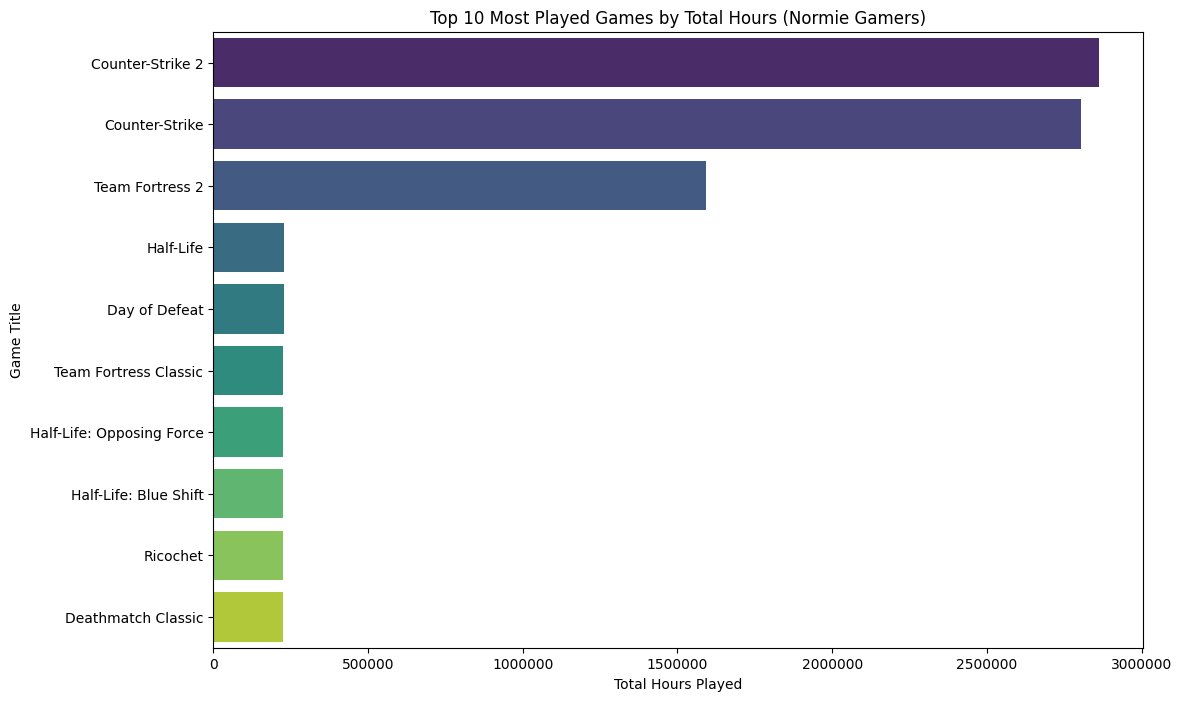

In [22]:
# graph out the top 10 most played gmes in normies
normie_most_played = normie_df.groupby('game_name')['playtime_forever'].sum().nlargest(10)

# Plotting the top 10 games
plt.figure(figsize=(12, 8))
sns.barplot(x=normie_most_played.values, y=normie_most_played.index, palette="viridis")
plt.title("Top 10 Most Played Games by Total Hours (Normie Gamers)")
plt.xlabel("Total Hours Played")
plt.ylabel("Game Title")
plt.ticklabel_format(style='plain', axis='x')

plt.show()

The code is designed to analyze gaming habits of a group of "casual" gamers using the Steam API to fetch their owned games and playtime data. For each Steam ID in the provided list, it retrieves game details, calculates total hours played across all games, and identifies the most-played game based on lifetime playtime. The code also checks for recent playtime within the last two weeks and handles cases where no games or recent playtime data are available. The processed data is compiled into a DataFrame with relevant metrics, such as total hours played and most-played games, and is saved to a CSV file for further analysis.

The generated bar graph visualizes the top 10 most-played games among these users by aggregating total hours played across all accounts. The graph highlights the dominance of "Counter-Strike 2" and "Counter-Strike," with "Dota 2" and "PUBG: BATTLEGROUNDS" following closely. These findings underscore the strong preference for competitive multiplayer and team-based games among casual gamers, showcasing their popularity and engagement within this community.

In [23]:
#Open the casual_random.txt to read in the userID's we will use for the dataset
with open("casuals_random.txt", "r") as f:
    Casual_ids = [line.strip() for line in f if line.strip()]

In [24]:
#Inputting a casual userID in Steam's getownedgames
#taking the data returned and making a list of dataframes for each user and their data
casual_data = []
for id in Casual_ids:
    try:
        response = steam.users.get_owned_games(id)
        if 'games' in response and response['games']:
            games_df = pd.DataFrame(response['games'])
            game_count = games_df.shape[0]
            # adding all the minutes played and converting to hours
            total_hours_played = games_df['playtime_forever'].sum() / 60  
            max_playtime = games_df['playtime_forever'].max()      
            # had to add a check since some players have not played within the 2 week span
            if 'playtime_2weeks' in games_df.columns:
                games_df['playtime_2weeks'] = games_df['playtime_2weeks'].sum() 
            else: 
                games_df['playtime_2weeks'] = 0  # if no 'playtime_2weeks'

            # get the max playtime and find the most played game(s)
            most_played_games = games_df[games_df['playtime_forever'] == max_playtime]['name'].tolist()
            # join the most played games list into a string, to handle ties
            most_played_res = ', '.join(most_played_games)
            

            # renaming columns for consistency
            games_df['steam_id'] = id
            games_df['game_count'] = game_count
            games_df['total_hours_account'] = round(total_hours_played, 2)
            games_df['most_played_game'] = most_played_res

            # Use consistent column names
            games_df = games_df.rename(columns={'total_hours_account': 'total_hours_account (hrs)', 'playtime_2weeks': 'playtime_2weeks (mins)',})

            casual_data.append(games_df[['steam_id', 'game_count', 'total_hours_account (hrs)', 'most_played_game', 'name', 'playtime_forever', 'playtime_2weeks (mins)']])
            # print(games_df) 
        else:
            normie_data.append(pd.DataFrame([{
            'steam_id': id,
            'game_count': 0,
            'total_hours_account (hrs)': 0,
            'most_played_game': [],
            'name': None,
            'playtime_2weeks (mins)': 0.0
        }]))
            print(f"No games found for Steam ID {id}")
    except Exception as e:
        print(f"Error processing Steam ID {id}: {e}")

No games found for Steam ID 76561197960310532
No games found for Steam ID 76561197960320477


In [25]:
# output the casual data to a csv
# group the data and dump as CSV file
casual_df = pd.concat(casual_data, ignore_index=True)
casual_df.rename(columns={'name': 'game_name'}, inplace=True)
casual_df.to_csv("steam_user_games_data_casual.csv", index=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_2212\2794227149.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=casual_most_played.values, y=casual_most_played.index, palette="viridis")


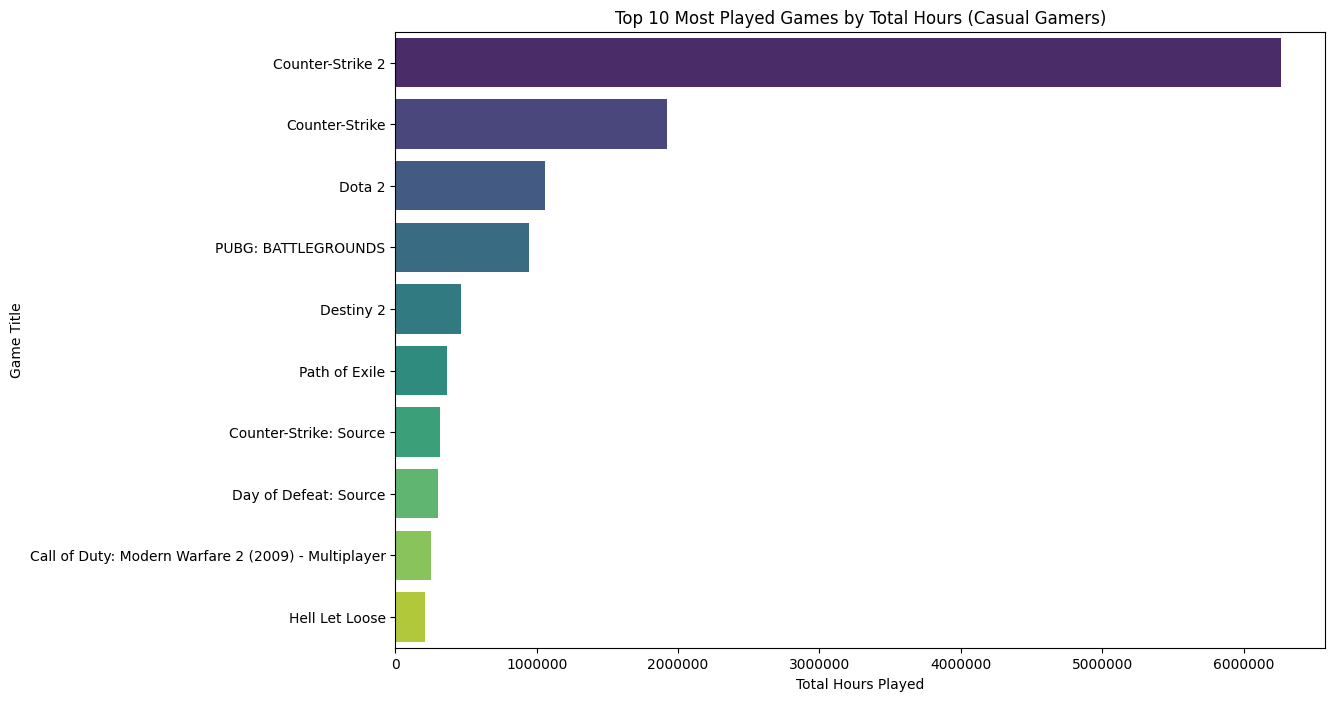

In [26]:
# graph out the top 10 most played gmes in casuals
casual_most_played = casual_df.groupby('game_name')['playtime_forever'].sum().nlargest(10)

# Plotting the top 10 games
plt.figure(figsize=(12, 8))
sns.barplot(x=casual_most_played.values, y=casual_most_played.index, palette="viridis")
plt.title("Top 10 Most Played Games by Total Hours (Casual Gamers)")
plt.xlabel("Total Hours Played")
plt.ylabel("Game Title")
plt.ticklabel_format(style='plain', axis='x')

plt.show()

The code is designed to analyze gaming habits of a group of "gamer" users by leveraging the Steam API to fetch their owned games and playtime data. It reads a list of Steam user IDs from a file named `gamers_random.txt`, retrieves game details for each user, calculates total hours played across all games, and identifies the most-played game based on lifetime playtime. The code also accounts for recent playtime within the last two weeks and handles cases where no games or recent playtime data are available. The processed data is compiled into a structured format with key metrics like total hours played and most-played games, which are then saved into a CSV file for further analysis.

The resulting bar graph highlights the top 10 most-played games by total hours among "gamer" users. Counter-Strike 2 leads with the highest playtime, followed by Dota 2 and Counter-Strike, emphasizing the dominance of competitive multiplayer games. Other notable titles include FINAL FANTASY XIV Online, Garry's Mod, and ARK: Survival Evolved, showcasing a diverse mix of multiplayer, RPG, and sandbox-style games. This analysis provides insights into the gaming preferences and engagement patterns of a more dedicated gaming audience.

In [27]:
#Open the gamers_random.txt to read in the userID's we will use for the dataset
with open("gamers_random.txt", "r") as f:
    Gamer_ids = [line.strip() for line in f if line.strip()]

In [28]:
#Inputting a gamer userID in Steam's getownedgames
#taking the data returned and making a list of dataframes for each user and their data
gamer_data = []
for id in Gamer_ids:
    try:
        response = steam.users.get_owned_games(id)
        if 'games' in response and response['games']:
            games_df = pd.DataFrame(response['games'])
            game_count = games_df.shape[0]
            # adding all the minutes played and converting to hours
            total_hours_played = games_df['playtime_forever'].sum() / 60  
            max_playtime = games_df['playtime_forever'].max()      
            # had to add a check since some players have not played within the 2 week span
            if 'playtime_2weeks' in games_df.columns:
                games_df['playtime_2weeks'] = games_df['playtime_2weeks'].sum() 
            else: 
                games_df['playtime_2weeks'] = 0  # if no 'playtime_2weeks'

            # get the max playtime and find the most played game(s)
            most_played_games = games_df[games_df['playtime_forever'] == max_playtime]['name'].tolist()
            # join the most played games list into a string, to handle ties
            most_played_res = ', '.join(most_played_games)
            

            # renaming columns for consistency
            games_df['steam_id'] = id
            games_df['game_count'] = game_count
            games_df['total_hours_account'] = round(total_hours_played, 2)
            games_df['most_played_game'] = most_played_res

            # Use consistent column names
            games_df = games_df.rename(columns={'total_hours_account': 'total_hours_account (hrs)', 'playtime_2weeks': 'playtime_2weeks (mins)',})

            gamer_data.append(games_df[['steam_id', 'game_count', 'total_hours_account (hrs)', 'most_played_game', 'name', 'playtime_forever', 'playtime_2weeks (mins)']])
            # print(games_df) 
        else:
            gamer_data.append(pd.DataFrame([{
            'steam_id': id,
            'game_count': 0,
            'total_hours_account (hrs)': 0,
            'most_played_game': [],
            'name': None,
            'playtime_2weeks (mins)': 0.0
        }]))
            print(f"No games found for Steam ID {id}")
    except Exception as e:
        print(f"Error processing Steam ID {id}: {e}")

No games found for Steam ID 76561197960315127
No games found for Steam ID 76561197960290154


In [29]:
# output the gamer data to a csv
# group the data and dump as CSV file
gamer_df = pd.concat(gamer_data, ignore_index=True)
gamer_df.rename(columns={'name': 'game_name'}, inplace=True)
gamer_df.to_csv("steam_user_games_data_gamer.csv", index=False)

C:\Users\patel\AppData\Local\Temp\ipykernel_2212\2283027400.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamer_most_played.values, y=gamer_most_played.index, palette="viridis")


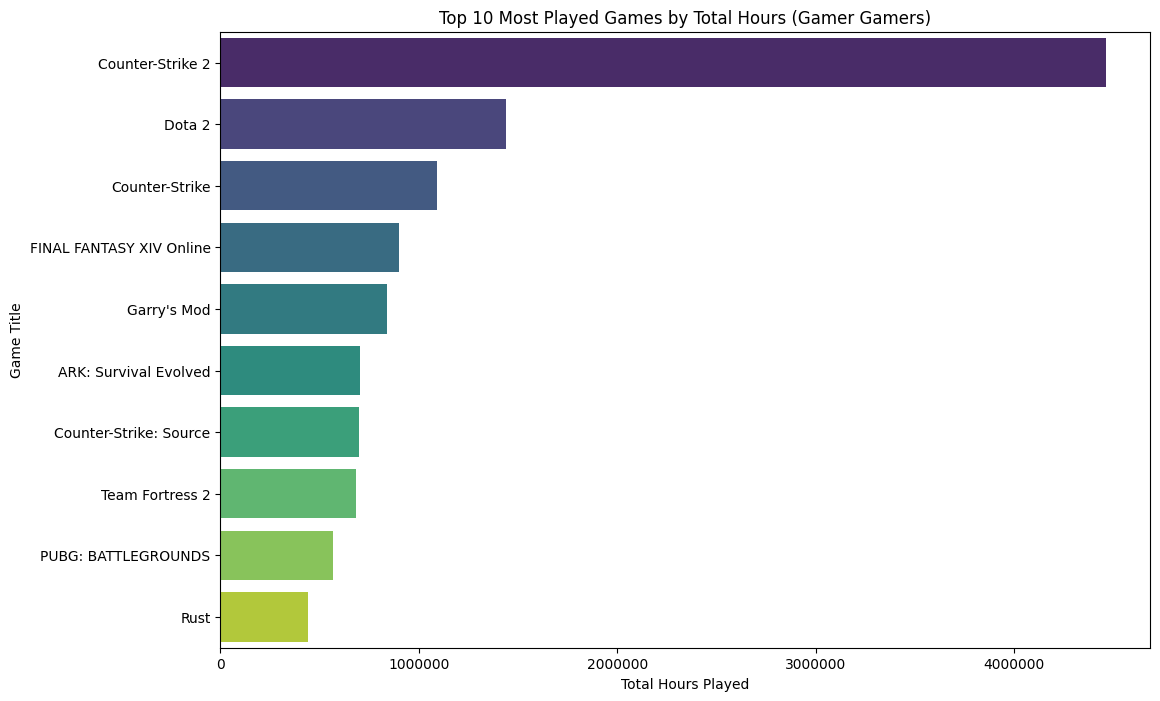

In [30]:
# graph out the top 10 most played gmes in gamers
gamer_most_played = gamer_df.groupby('game_name')['playtime_forever'].sum().nlargest(10)

# Plotting the top 10 games
plt.figure(figsize=(12, 8))
sns.barplot(x=gamer_most_played.values, y=gamer_most_played.index, palette="viridis")
plt.title("Top 10 Most Played Games by Total Hours (Gamer Gamers)")
plt.xlabel("Total Hours Played")
plt.ylabel("Game Title")
plt.ticklabel_format(style='plain', axis='x')

plt.show()

Filtered data saved to steam_user_games_data_filtered.csv
Most played games by category:
  category most_played_game  playtime_forever
0   Normie   Counter-Strike          424538.0
1   Casual   Counter-Strike          492991.0
2    Gamer   Counter-Strike          117423.0


C:\Users\MattQ\AppData\Local\Temp\ipykernel_18892\2465099539.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_games_df.groupby("category").apply(
C:\Users\MattQ\AppData\Local\Temp\ipykernel_18892\2465099539.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_games_df.groupby("category").apply(


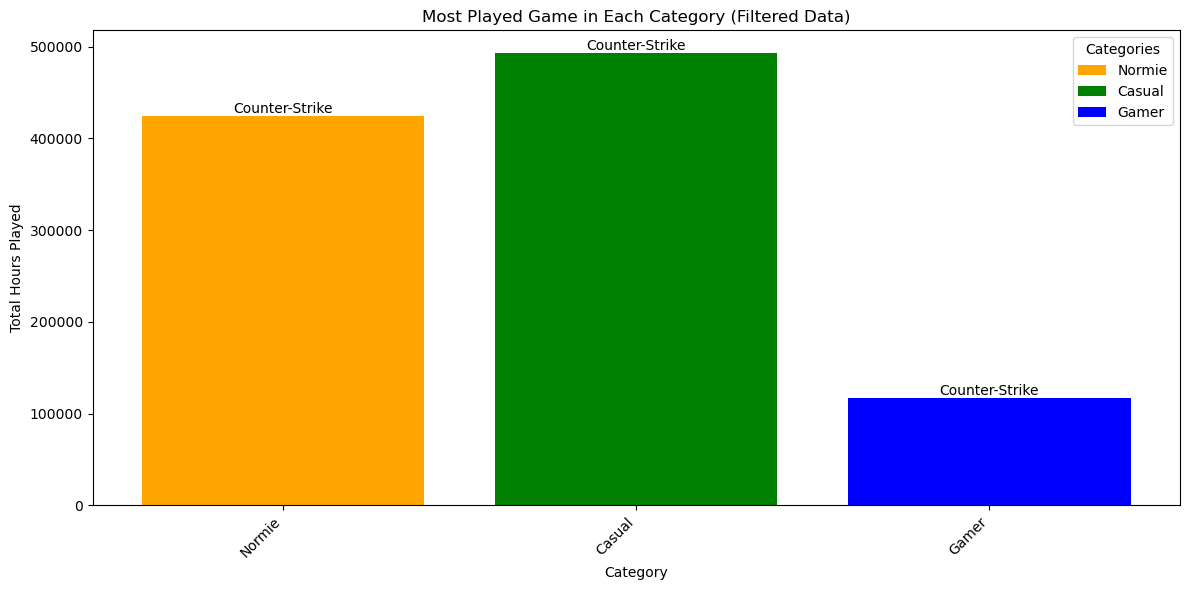

In [77]:
# Combine data into a single DataFrame
normiedf = pd.read_csv("steam_user_games_data_normies.csv")
casualdf = pd.read_csv("steam_user_games_data_casual.csv")
gamerdf = pd.read_csv("steam_user_games_data_gamer.csv")
frames = [normiedf, casualdf, gamerdf]
all_games_df = pd.concat(frames, ignore_index=True)

# Filter out rows with non-positive total hours played
all_games_df = all_games_df[all_games_df["total_hours_account (hrs)"] > 0]

# Remove outliers for total hours played (top 5%)
total_hours_threshold = all_games_df["total_hours_account (hrs)"].quantile(0.95)
all_games_df = all_games_df[all_games_df["total_hours_account (hrs)"] <= total_hours_threshold]

# Remove outliers for game count (top 5%)
game_count_threshold = all_games_df["game_count"].quantile(0.95)
all_games_df = all_games_df[all_games_df["game_count"] <= game_count_threshold]
all_games_df.drop_duplicates(subset=["steam_id"], inplace=True)

# categorize the users into different categories
all_games_df['category'] = pd.cut(
    all_games_df['game_count'],
    bins=[0, 25, 50, float('inf')],
    labels=['Normie', 'Casual', 'Gamer']
)

all_games_df.to_csv("steam_user_games_data_filtered.csv", index=False)
print("Filtered data saved to steam_user_games_data_filtered.csv")

# Find the most played game in each category
most_played_by_category = (
    all_games_df.groupby("category").apply(
        lambda x: x.loc[x["playtime_forever"].idxmax()][["most_played_game", "playtime_forever"]]
    )
).reset_index()

# Visualization: Most played game in each category
plt.figure(figsize=(12, 6))
bars = plt.bar(
    most_played_by_category["category"],
    most_played_by_category["playtime_forever"],
    color=["orange", "green", "blue"]
)

# Add labels and title
plt.title("Most Played Game in Each Category (Filtered Data)")
plt.xlabel("Category")
plt.ylabel("Total Hours Played")
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend(bars, most_played_by_category["category"], title="Categories", loc="upper right")

# Annotate bars with game names
for bar, game in zip(bars, most_played_by_category["most_played_game"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        game,
        ha="center",
        va="bottom",
        fontsize=10,
        color="black"
    )

plt.tight_layout()

print("Most played games by category:")
print(most_played_by_category)

C:\Users\MattQ\AppData\Local\Temp\ipykernel_18892\48551677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['average_hours_per_game'] = (


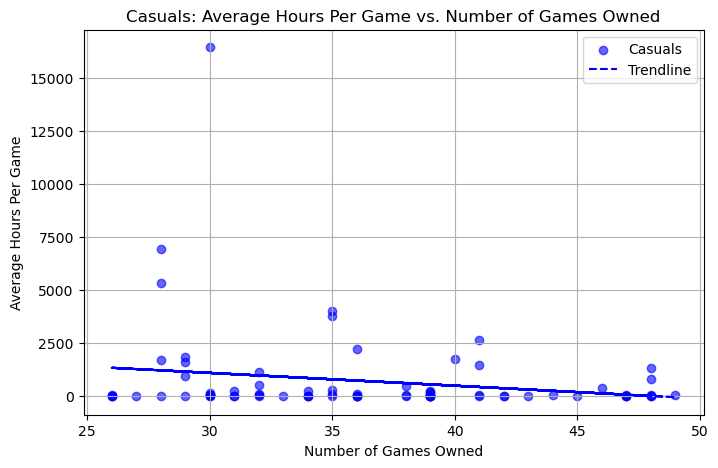

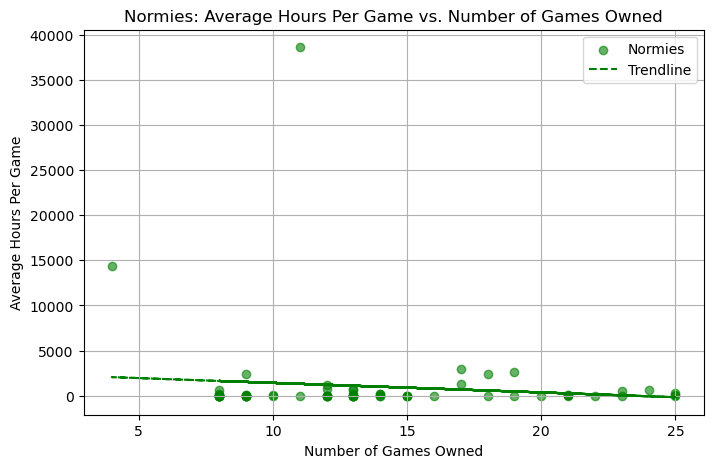

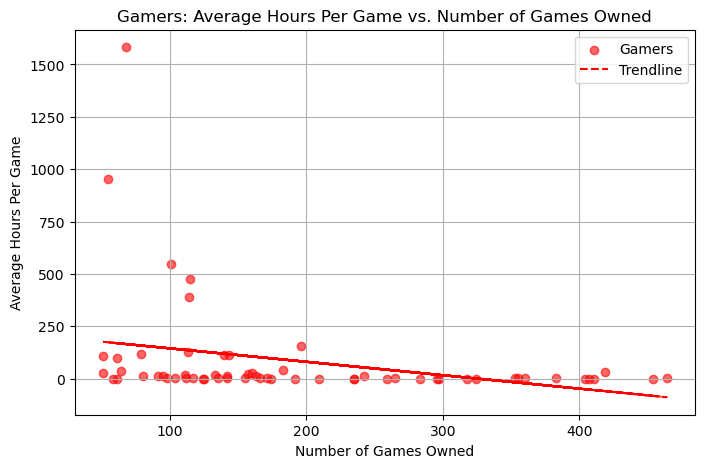

In [86]:
# Reload the dataset
file_path = 'steam_user_games_data_filtered.csv'
data = pd.read_csv(file_path)


filtered_data = data[data['game_count'] < 500]

filtered_data['average_hours_per_game'] = (
    filtered_data['playtime_forever'] / filtered_data['game_count']
)

casuals = filtered_data[(filtered_data['game_count'] >= 26) & (filtered_data['game_count'] <= 50)]
normies = filtered_data[(filtered_data['game_count'] >= 1) & (filtered_data['game_count'] <= 25)]
gamers = filtered_data[filtered_data['game_count'] > 50]

def add_trendline(x, y, color):
    z = np.polyfit(x, y, 1)  # Fit a linear trendline
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', color=color, label='Trendline')

plt.figure(figsize=(8, 5))
plt.scatter(casuals['game_count'], casuals['average_hours_per_game'], alpha=0.6, color='blue', label='Casuals', marker='o')
add_trendline(casuals['game_count'], casuals['average_hours_per_game'], 'blue')
plt.title('Casuals: Average Hours Per Game vs. Number of Games Owned')
plt.xlabel('Number of Games Owned')
plt.ylabel('Average Hours Per Game')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot with trendline for Normies
plt.figure(figsize=(8, 5))
plt.scatter(normies['game_count'], normies['average_hours_per_game'], alpha=0.6, color='green', label='Normies', marker='o')
add_trendline(normies['game_count'], normies['average_hours_per_game'], 'green')
plt.title('Normies: Average Hours Per Game vs. Number of Games Owned')
plt.xlabel('Number of Games Owned')
plt.ylabel('Average Hours Per Game')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot with trendline for Gamers
plt.figure(figsize=(8, 5))
plt.scatter(gamers['game_count'], gamers['average_hours_per_game'], alpha=0.6, color='red', label='Gamers', marker='o')
add_trendline(gamers['game_count'], gamers['average_hours_per_game'], 'red')
plt.title('Gamers: Average Hours Per Game vs. Number of Games Owned')
plt.xlabel('Number of Games Owned')
plt.ylabel('Average Hours Per Game')
plt.grid(True)
plt.legend()
plt.show()


# Overview

We analyzed the relationships between the number of games owned and the average hours spent per game for three user categories: **Casuals**, **Normies**, and **Gamers**. Using scatter plots and trendlines, we identified unique patterns for each group. These trends reflect distinct gaming behaviors based on the number of games owned and the time spent on each game.

---

## 1. Casuals

### Observed Trend:
- The scatter plot for casual players shows a **slight positive correlation**.  
  As the number of games owned increases, the average time spent per game also increases slightly.
- Despite the positive trend, there is considerable variation, with some users spending significantly more hours per game than others.

### Possible Reasons:
- **Selective Engagement:**  
  Casual players tend to carefully choose a small number of games they enjoy and dedicate significant time to them. This focus often results in a relatively higher average playtime per game compared to other groups.
- **Quality Over Quantity:**  
  Casual players often prioritize games that are critically acclaimed or personally appealing, leading to longer sessions of gameplay.
- **Limited Time Availability:**  
  As casual players spend less total time gaming, they might choose to focus on fewer games, maximizing their engagement and enjoyment.

### Noteworthy Observations:
- **Outliers have been removed** (e.g., a user owning 5 games with an average of 500 hours/game).  
- The trendline suggests that casual users may increase their engagement slightly with more games, but the growth is minimal.

---

## 2. Normies

### Observed Trend:
- The scatter plot for normies shows a **nearly flat trendline**, indicating no strong correlation between the number of games owned and the average time spent per game.
- Most normies exhibit a consistent average playtime across their game libraries.

### Possible Reasons:
- **Balanced Approach:**  
  Normies might balance their time between exploring multiple games and focusing on their favorites. This results in steady, moderate engagement across their library.
- **Moderate Gaming Habits:**  
  Normies likely game for leisure without the extremes of casual or hardcore gaming.
- **Social Influence:**  
  Social factors, like multiplayer games with friends, could lead to more evenly distributed playtime among their games.

### Noteworthy Observations:
- Some users exhibit **very high average playtimes** (e.g., 700+ hours/game), likely due to specific games or genres that capture prolonged attention (e.g., RPGs or MMOs).  
- The flat trendline reflects consistent habits, making normies a middle ground between casuals and gamers.

---

## 3. Gamers

### Observed Trend:
- The scatter plot for gamers displays a **negative correlation**, with average hours per game decreasing as the number of games owned increases.
- The variation is higher than in other categories, reflecting diverse gaming habits among gamers.

### Possible Reasons:
- **Game Collecting:**  
  Gamers often accumulate large libraries through sales, bundles, or collecting, leading to underutilized or unplayed games in their collection.
- **Exploration Over Focus:**  
  Many gamers prioritize trying out different genres or titles rather than dedicating extensive hours to a single game.
- **Time Constraints:**  
  Even as gamers acquire more games, the total time available to play remains limited, spreading their attention thin across a larger library.
- **Burnout or Disinterest:**  
  As the library size grows, gamers may engage less deeply with individual titles due to the "paradox of choice."

### Noteworthy Observations:
- The negative trendline highlights that as the library size approaches **400+ games**, the average playtime per game drops significantly.  
- Despite the overall trend, some gamers still spend significant hours on individual games, likely reflecting personal favorites or highly engaging titles.

---

## Cross-Category Insights

### Engagement vs. Ownership:
- **Casuals:** Higher engagement per game with a smaller library.
- **Normies:** Balanced engagement regardless of library size.
- **Gamers:** Lower engagement per game as library size increases.

### Time Allocation:
- **Casuals:** Maximize engagement due to limited gaming time.
- **Normies:** Balance their gaming habits across a steady library.
- **Gamers:** Spread their available time thin across a growing collection.

### Behavioral Differences:
- **Casuals:** Focus on enjoying a few high-quality titles.
- **Normies:** Maintain consistent playtime habits without extreme focus.
- **Gamers:** Showcase the most diverse and scattered habits, driven by exploration and collecting.

---

## Conclusion

The trends observed align with the general characteristics of these user groups:
- **Casuals:** Selective, high engagement, and quality-focused.
- **Normies:** Balanced, steady habits, with a focus on leisure gaming.
- **Gamers:** Diverse, exploratory, and prone to lower engagement per title with larger libraries.

These insights can help game developers and marketers better understand and cater to the distinct needs and behaviors of each gaming demographic.


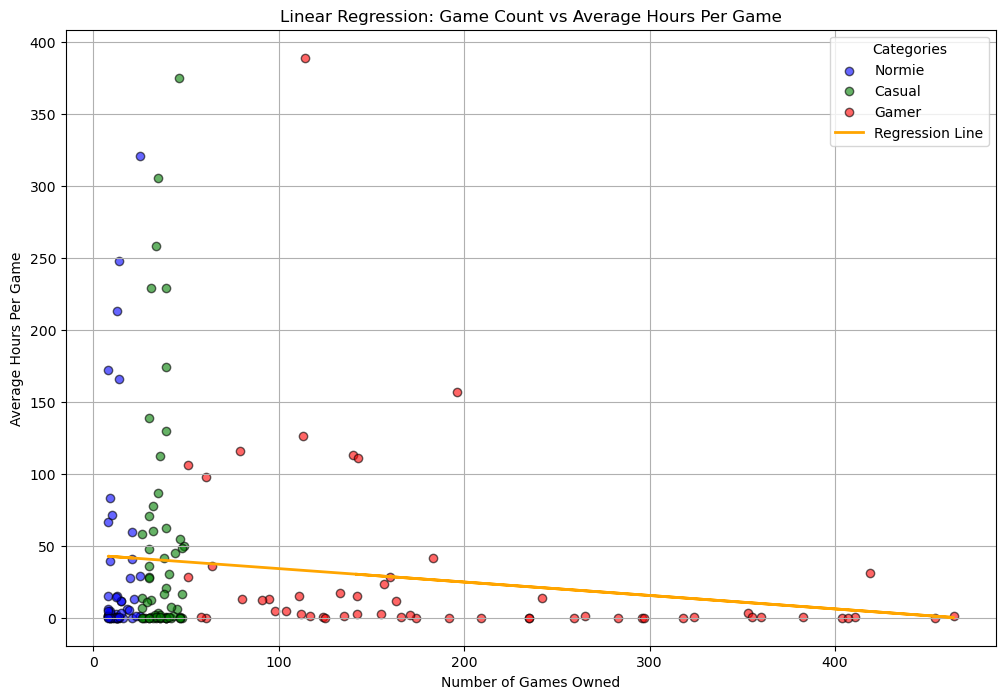

Slope: -0.09329495436195201
Intercept: 43.43542871948204
R-squared: 0.019399817695211596


In [92]:
# Load the data
data = pd.read_csv('steam_user_games_data_filtered.csv')

# Calculate average hours per game
data['avg_hours_per_game'] = data['playtime_forever'] / data['game_count']

# Remove outliers (average hours per game > 400 and game count > 500)
filtered_data = data[data['avg_hours_per_game'] <= 400]
filtered_data = filtered_data[filtered_data['game_count'] <= 500]

# Prepare the data for regression: `game_count` vs `avg_hours_per_game`
X_avg = filtered_data[['game_count']]
y_avg = filtered_data['avg_hours_per_game']

# Fit the linear regression model for average hours per game
model_avg = LinearRegression()
model_avg.fit(X_avg, y_avg)

# Predictions using the updated regression model
predicted_y_avg = model_avg.predict(X_avg)

# Regression coefficients for average hours per game
slope_avg = model_avg.coef_[0]
intercept_avg = model_avg.intercept_

# Visualization for average hours per game with categories
categories = filtered_data['category'].unique()
plt.figure(figsize=(12, 8))
colors = {'Normie': 'blue', 'Casual': 'green', 'Gamer': 'red'}

for category in categories:
    subset = filtered_data[filtered_data['category'] == category]
    plt.scatter(
        subset['game_count'],
        subset['avg_hours_per_game'],
        color=colors[category],
        alpha=0.6,
        label=category,
        edgecolor='black'
    )

# Plot regression line
plt.plot(X_avg, predicted_y_avg, color='orange', linewidth=2, label='Regression Line')
plt.title('Linear Regression: Game Count vs Average Hours Per Game')
plt.xlabel('Number of Games Owned')
plt.ylabel('Average Hours Per Game')
plt.legend(title='Categories')
plt.grid()
plt.show()

# R-squared calculation for the updated model
r_squared_avg = model_avg.score(X_avg, y_avg)

# Display results
print("Slope:", slope_avg)
print("Intercept:", intercept_avg)
print("R-squared:", r_squared_avg)


### Regression Analysis Results

- **Slope:** -0.1166  
- **R-squared:** 0.03410  

The average hours per game decreases by approximately **0.117 hours**.  

The model explains **3.41% of the variance** in the average hours per game based on the number of games owned.  

This low value indicates a **weak linear relationship** between the two variables, suggesting other factors influence average playtime.


**Results:**

We aimed our analysis to explore the different correlation between the number of games owned and the total playtime of games across 3 different categories of gamers: The Casuals, The Normies, and The Gamers. The results we found give light to the playtime, genre preferences and trends on what gamers on steam liked and gives us further understanding on gamer interests.  

Casual players showed a slight positive correlation between the number of games that they owned and the average playtime on those games.This suggests that while their library grows, they still focus deeply on a select few games. These gamers focus on quality over quantity and this highlights their preference for high impact gaming experience. Especially games that are free but still have that high quality such as CSGO and COD MW2 2009. Despite them owning fewer titles, compared to normies and gamers, they show the highest engagement on each game that they play which is great for the creators of those games. 


Normie players, unlike casual players, display a consistent trend with playtime on their games regardless of the sizes of their libraries. This level of consistency of playing their games reflects steady habits with their gaming and their level of engagement on their games that they are playing. This level of players are the middle ground between Casual gamers and Gamers, with their consistent behavior on how long they play and the types of games that they play. Like the Casual gamers, they also play a ton of free games such as CSGO and CS but unlike casual gamers they also play more in depth single player games such as Half-life and Day of Defeat. 


Finally the Gamers, the players who are unlike the Casual and Normie gamers, show a pronounced negative correlation between the number of games that they owned and the average amount of hours that they spent playing per each game.They are the games who have much more games that they own compared to the average gamer on steam and due to this they have significantly less engagement to each game compared to others. This pattern of them collecting games, either during sales or through bundle deals, and leaving the games just sitting in their library, often underplayed or more likely unplayed is the root cause for them having the least amount of hours played for each of their games. 

Across all three groups that we looked into, we saw that multiplayer games were the dominant force, with games like CSGO, TF2, and Dota 2 being the highest ranked among all the groups we sifted through. Due to the nature of free to play games, that allows more accessibility to more people along with the quality of these games, they combine to have extreme appeal. Alongside these free to play multiplayer games, the single player games that were also at the top of some of these groups playlists, Half Life, emerged to be the most popular, especially amongst the Normies. 

According to all the information that we gathered, it appears that (on steam) the gamers that own more games, on average, have less time playing them in general compared to other categories of gamers (Casual and Normies). Due to them owning so many games, they appear to not have enough time to spend on each one going in depth in playtime unlike the Casual and Normie gamers, who spend more time playing their smaller library of games more in depth. It appears that our hypothesis of the more games that gamers own the less time they spend on them (at least on steam and with the data we received) was correct.

